<a href="https://colab.research.google.com/github/vadim-privalov/Neiroset_Novosibirsk/blob/main/%D0%9E%D0%B1%D1%83%D1%87%D0%B0%D0%B5%D0%BC_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C_%D1%80%D0%B0%D1%81%D0%BF%D0%BE%D0%B7%D0%BD%D0%B0%D0%B2%D0%B0%D1%82%D1%8C_%D1%80%D1%83%D0%BA%D0%BE%D0%BF%D0%B8%D1%81%D0%BD%D1%8B%D0%B9_%D1%82%D0%B5%D0%BA%D1%81%D1%82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обучаем модель распознавать рукописный текст 

# Teaching the model to recognize handwriting 


В этом уроке мы научимся, как обучать модель оптического распознавания символов (**OCR**) на основе модели **ResNet** с помощью Keras и TensorFlow.

In this lesson, we will learn how to train an Optical Character Recognition (**OCR**) model based on the **ResNet** model using Keras and TensorFlow.

Делать мы это будем на основе **MNIST** датасета и второго набора данных для символом **A–Z**. 

We will do it based on **MNIST** dataset and the second dataset for symbols **A-Z**. 

**MNIST** - это стандартный датасет, состоящий из изображений цифр от 0 до 9. Его  мы возьмем из библиотеки TensorFlow, а датасет, состоящий из  букв, скачаем с **Kaggle** (после распаковки .zip архива со всеми файлами это набор будет уже установлен у вас). Данный набор данных состоит из прописных букв A–Z из специальной базы данных NIST 19 преобразованных под удобный нам формат ( 28 x 28 в оттенках серого). Он нам удобен, так как такой же формат в MNIST.




**MNIST** is a standard dataset, consisting of images of digits from 0 to 9. It is taken from the TensorFlow library, and the dataset, consisting of letters, is downloaded from **Kaggle** (after unpacking the .zip archive with all the files this dataset will be installed on your computer). This dataset consists of uppercase letters A-Z from a special database of NIST 19 converted to our convenient format (28 x 28 in shades of gray). It is convenient for us because it is the same format in MNIST.

In [1]:
# установим и распакуем архив
# install and unpack the archive
!wget http://dataudt.ru/datasets/cv/Lesson_05.Train_OCR.zip
!unzip -qq Lesson_05.Train_OCR.zip
%cd Train_OCR

--2022-02-12 10:42:20--  http://dataudt.ru/datasets/cv/Lesson_05.Train_OCR.zip
Resolving dataudt.ru (dataudt.ru)... 37.228.117.130
Connecting to dataudt.ru (dataudt.ru)|37.228.117.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98493373 (94M) [application/zip]
Saving to: ‘Lesson_05.Train_OCR.zip’

Lesson_05.Train_OCR 100%[===================>]  93.93M  19.4MB/s    in 5.7s    

2022-02-12 10:42:27 (16.4 MB/s) - ‘Lesson_05.Train_OCR.zip’ saved [98493373/98493373]

/content/Train_OCR


In [2]:
# импортируем необходимые пакеты
# import the necessary packages
from google.colab.patches import cv2_imshow # для отображения картинок в колабе 
                                            # to display pictures in the colab 
from tensorflow.keras.datasets import mnist # датасет с mnist 
                                            # dataset with mnist 
from models import ResNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD # алгоритм оптимизации стохастического градиентного спуска 
                                            # stochastic gradient descent optimization algorithm 
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import build_montages # воспомогательная функция для обработки изображения
                                    # Auxiliary function for image processing 
import matplotlib.pyplot as plt
import numpy as np
import cv2


In [3]:
# настроим matplotlib так, чтобы рисунки можно было сохранять автоматически 
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

Далее напишем вспомогательные функции для загрузки данных



Next, we will write auxiliary functions to load the data


In [4]:
def load_az_dataset(datasetPath):
    # инициализируем список данных и меток
	# initialize the list of data and labels
	data = []
	labels = []

    # поочередно перебираем набор  букв от A до Z построчно 
	# loop over the rows of the A-Z handwritten digit dataset
	for row in open(datasetPath):
        # достаем метку и изображение из строки
		# parse the label and image from the row
		row = row.split(",")
		label = int(row[0])
		image = np.array([int(x) for x in row[1:]], dtype="uint8")
  
        # изображения представлены как одноканальные (в оттенках серого).
        # размером 28x28 = 784 пикселя - нам нужно взять этот плоский
        # 784-d список чисел и преобразовать их в матрицу 28x28

		# images are represented as single channel (grayscale) images
		# that are 28x28=784 pixels -- we need to take this flattened
		# 784-d list of numbers and repshape them into a 28x28 matrix
    
        # изображения представлены как одноканальные (в оттенках серого) 
        # преобразуем их в матрицу размера 28x28
        # images are presented as single channel (grayscale)
        # convert them to a 28x28 matrix
		image = image.reshape((28, 28))

        # обновляем список данных и меток
		# update the list of data and labels
		data.append(image)
		labels.append(label)

    # преобразовываем данные и метки в NumPy массивы 
	# convert the data and labels to NumPy arrays 
	data = np.array(data, dtype="float32")
	labels = np.array(labels, dtype="int")

    # возвращаем кортеж, состоящий из данных и их меток 
	# return a 2-tuple of the A-Z data and labels
	return (data, labels)

In [5]:
def load_mnist_dataset():
    # загружаем набор данных MNIST, соединяя тестовые и тренировочные данные 
	# load the MNIST dataset and stack the training data and testing
	# data together (we'll create our own training and testing splits
	# later in the project)
	((trainData, trainLabels), (testData, testLabels)) = mnist.load_data()
	data = np.vstack([trainData, testData])
	labels = np.hstack([trainLabels, testLabels])

    # возвращаем кортеж, состоящий из данных и их меток 
	# return a 2-tuple of the MNIST data and labels
	return (data, labels)

Настроим аргументы 

Let's set up the arguments 


In [6]:
# создадим отдельный словарь с аргументами 
# create a separate dictionary with arguments 

args = {
  "az" : "a_z_handwritten_data.csv", # расположение датасета для букв 
                                    # dataset location for letters 
	"model": "handwriting.model", # сюда сохраняется обученная модель ResNet
                                    # the ResNet trained model is saved here
	"plot": "plot.png" # сюда будет записываться результаты самого последнего запуска
                        # the results of the most recent run will be recorded here
}

In [7]:
# укажем гиперпараметры 
# initialize the number of epochs to train for, initial learning rate,
# and batch size
EPOCHS = 50 # кол-во эпох
            # number of epochs
INIT_LR = 1e-1 # начальную скорость обучения
               # initial learning rate
BS = 128 # размер одного батча
         # the size of one batt

Работаем с данными, всячески преобразовывая

Working with data, transforming it in all kinds of ways


In [8]:
# загружаем наборы данных
# load the A-Z and MNIST datasets, respectively
print("[INFO] loading datasets...")
(azData, azLabels) = load_az_dataset(args["az"]) 
(digitsData, digitsLabels) = load_mnist_dataset()

[INFO] loading datasets...
11501568/11490434 [==============================] - 0s 0us/step


In [9]:
# Так как мы работает одноврменно с 2 датасетами,то нам надо сделать так, 
# чтобы они не пересекались. Для этого добавим + 10 ко всем меткам  A-Z, так
# как первые 10 значений будут выделены по цифры от 0 до 9 
# the MNIST dataset occupies the labels 0-9, so let's add 10 to every
# A-Z label to ensure the A-Z characters are not incorrectly labeled
# as digits
azLabels += 10

# соединяем данные и метки 
# stack the A-Z data and labels with the MNIST digits data and labels
data = np.vstack([azData, digitsData])  
labels = np.hstack([azLabels, digitsLabels]) 

# все изображения в нашем датасете имеют размер 28x28, а архитектура, 
# которую мы используем принимает 32x32, поэтому исправим этот момент 
# each image in the A-Z and MNIST digts datasets are 28x28 pixels;
# however, the architecture we're using is designed for 32x32 images,
# so we need to resize them to 32x32
data = [cv2.resize(image, (32, 32)) for image in data]
data = np.array(data, dtype="float32")

# добавляем размер канала к каждому изображению в наборе данных и
# масштабируем интенсивность пикселей изображений от [0, 255] до [0,1]
# add a channel dimension to every image in the dataset and scale the
# pixel intensities of the images from [0, 255] down to [0, 1]
data = np.expand_dims(data, axis=-1)
data /= 255.0


In [10]:

# преобразуем метки из целых чисел в векторы
# convert the labels from integers to vectors
le = LabelBinarizer()
labels = le.fit_transform(labels)
counts = labels.sum(axis=0)

# учитываем перекос в размеченных данных
# account for skew in the labeled data
classTotals = labels.sum(axis=0)
classWeight = {}

# создаем цикл по всем классам,  вычисляя веса  
# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]

# делим на тестовые и тренировочные данные в соотношении 80/20
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.20, stratify=labels, random_state=42)


In [11]:
# строим генератор изображений для увеличения данных
# мы добавляем различные повороты, масштабируем, делаем горизонтальные переводы,
# вертикальные переводы и наклоны изображений, тем самым увеличивая размер датасета 
# construct the image generator for data augmentation
# we add different rotations, scale, do horizontal translations,
# vertical translations and slanting of images, thereby increasing the size of the dataset
aug = ImageDataGenerator(
	rotation_range=10,
	zoom_range=0.05,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
	horizontal_flip=False,
	fill_mode="nearest")

После всех преобразований можем и начать обучение, но сперва инициализируем модель ResNet.

After all the transformations we can start training, but first we initialize the ResNet model.

> **ResNet (Residual Network)** - успешная и довольно популярная архитектура глубокого обучения, основанная на CNN




> **ResNet (Residual Network)** - a successful and quite popular deep learning architecture based on CNN
 

In [12]:
# инициализируем и компилируем нашу нейронную сеть
# initialize and compile our deep neural network
print("[INFO] compiling model...")
opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model = ResNet.build(32, 32, 1, len(le.classes_), (3, 3, 3),
	(64, 64, 128, 256), reg=0.0005)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])


[INFO] compiling model...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


В коде выше мы строим ResNet на основе оптимизатора SGD и стандартного графика снижения скорости обучения (“categorical_crossentropy”). Каждый элемент представляется как матрица размером 32 × 32 в серых оттенках.


In the code above, we build ResNet based on the SGD optimizer and the standard learning rate reduction graph ("categorical_crossentropy"). Each element is represented as a 32 × 32 matrix in gray shades.

Будьте готовы: модель обучается достаточно долго и это нормально  

Be prepared: the model takes quite a long time to learn, and this is normal  

In [13]:
# тренируем сеть
# train the network
print("[INFO] training network...")
H = model.fit(
  aug.flow(trainX, trainY, batch_size=BS),
  validation_data=(testX, testY),
  steps_per_epoch=len(trainX) // BS,
  epochs=EPOCHS,
  class_weight=classWeight,
  verbose=1) # verbose показывает индикатор выполнения процесса 
             # verbose shows the process progress bar 

# определяем список названий меток
# define the list of label names
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]

# оцениваем сеть
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1),
  predictions.argmax(axis=1), target_names=labelNames)) # выводим результаты 
                                                        # outputs the results

# сохраняем модель на диск 
# save the model to disk
print("[INFO] serializing network...")
model.save(args["model"], save_format="h5")

[INFO] training network...
Epoch 1/50
2765/2765 [==============================] - 437s 153ms/step - loss: 1.8354 - accuracy: 0.8730 - val_loss: 0.5442 - val_accuracy: 0.8958
Epoch 2/50
2765/2765 [==============================] - 424s 153ms/step - loss: 0.9172 - accuracy: 0.9315 - val_loss: 0.5813 - val_accuracy: 0.8754
Epoch 3/50
2765/2765 [==============================] - 431s 156ms/step - loss: 0.8345 - accuracy: 0.9375 - val_loss: 0.5519 - val_accuracy: 0.8816
Epoch 4/50
2765/2765 [==============================] - 432s 156ms/step - loss: 0.7956 - accuracy: 0.9411 - val_loss: 0.5424 - val_accuracy: 0.8800
Epoch 5/50
2765/2765 [==============================] - 431s 156ms/step - loss: 0.7620 - accuracy: 0.9437 - val_loss: 0.5300 - val_accuracy: 0.8866
Epoch 6/50
2765/2765 [==============================] - 424s 153ms/step - loss: 0.7463 - accuracy: 0.9458 - val_loss: 0.4596 - val_accuracy: 0.9269
Epoch 7/50
2765/2765 [==============================] - 425s 154ms/step - loss: 0.727

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


По окончанию обучения нарисуется график и сохранится модель 

At the end of the training, the graph will be drawn and the model will be saved 


In [14]:
# строим график, который будет отображать и сохранять историю тренировок
# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"]) # график кривых потерь обучения сохраняется в файле, который мы указали в аргументах 
                          # the graph of learning loss curves is saved in the file that we specified in the arguments

Если вы по каким-то причинам не дождались окончания обучения модели, то можете раскомментировать код ниже и запустить уже обученную модель


If for some reason you did not wait until the end of model training, you can uncomment the code below and run the already trained model

In [ ]:
# labelNames = "0123456789"
# labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
# labelNames = [l for l in labelNames]
# from tensorflow.keras.models import load_model
# model = load_model('pretrained_handwriting.model')

In [15]:
# инициализируем список выходных изображений
# initialize our list of output images
images = []

# случайным образом выбираем несколько тестовых символов
# randomly select a few testing characters
for i in np.random.choice(np.arange(0, len(testY)), size=(49,)):
  # классифицируем символы при помощи нашей модели 
  # classify the character
  probs = model.predict(testX[np.newaxis, i])
  prediction = probs.argmax(axis=1)
  label = labelNames[prediction[0]]

  # извлекаем изображение из тестовых данных
  # инициализируем цвет текстовой метки зеленым цветом
  # extract the image from the test data and initialize the text
  # label color as green (correct)
  image = (testX[i] * 255).astype("uint8")
  color = (0, 255, 0)

  # если результаты сети не совпадаю с правильными метками, 
  # то изменяем цвет на крассный
  # if the network results do not match the correct labels, 
  # change the color to red
  if prediction[0] != np.argmax(testY[i]):
    color = (0, 0, 255)

  # объединяем каналы в одно изображение, изменяем размер изображения
  # с 32x32 до 96x96 для лучшего восприятния картинки (чисто для удобства),
  # а затем рисуем предсказанную метку на изображении нужным цветом 
  # merge the channels into one image, resize the image from 32x32
  # to 96x96 so we can better see it and then draw the predicted
  # label on the image
  image = cv2.merge([image] * 3)
  image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
  cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
    color, 2)

  # добавляем изображение в список выходных изображений
  # add the image to our list of output images
  images.append(image)


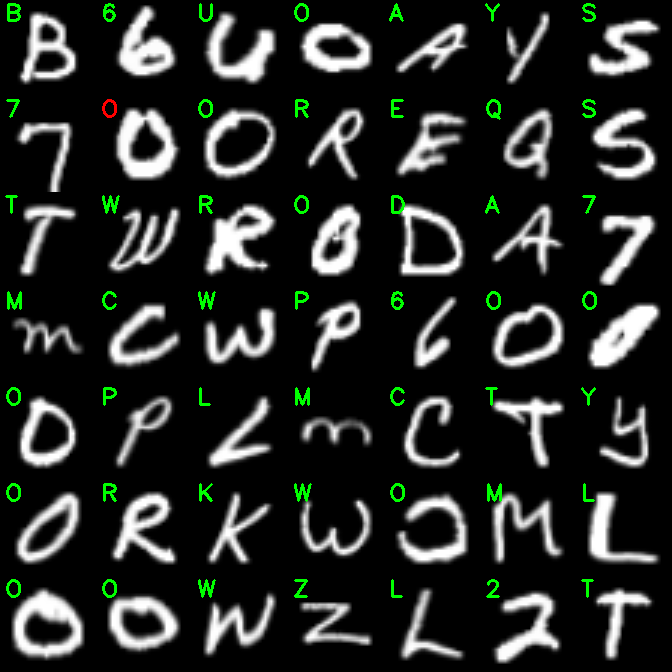

In [16]:
# строим монтаж для изображений
# construct the montage for the images
montage = build_montages(images, (96, 96), (7, 7))[0]

# выводим полученные результаты 
# show the output montage
cv2_imshow(montage)
